## Train MLP and CatBoost Models for Custom Target Variable

This notebook trains an ensemble of MLP models and a CatBoost model for a user-defined `TARGET_VAR`, such as `OPS`, `WAR`, or `RBI`. All saved models and scalers will be stored in a separate directory under `models/ensemble_engineered/{TARGET_VAR}`.


In [1]:
import sys
import os

# Add the src directory to path so we can import config, data_utils, etc.
sys.path.append(os.path.abspath("../src"))


In [2]:
import numpy as np
import pandas as pd
import torch
import joblib
import torch.nn as nn
from pybaseball import batting_stats
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import shap
import itertools
import random
import math
import pickle
from joblib import Parallel, delayed
import glob
import warnings
warnings.filterwarnings('ignore')

/Users/ak11/Desktop/Miscellaneous/Projects/baseball/mlb-performance-predictor/.venv310v3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# !pip install torch torchvision torchaudio --quiet
import torch
print(torch.__version__)
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

2.1.0
True
True


In [4]:
TARGET_VAR = 'OPS'  # Change to the stat you want to predict, e.g., 'WAR', 'RBI', etc.

### Load Dependencies and Set Up Environment

This cell imports all required packages and modules, sets the PyTorch device (CPU or Apple MPS), and prepares the runtime for model training and evaluation.


In [5]:
years = {}
for year in range(1990, 2024):
    try:
        df = batting_stats(year)
        df['Season'] = year
        years[year] = df
        print(f"Loaded {year}")
    except Exception as e:
        print(f"Failed to load {year}: {e}")

Loaded 1990
Loaded 1991
Loaded 1992
Loaded 1993
Loaded 1994
Loaded 1995
Loaded 1996
Loaded 1997
Loaded 1998
Loaded 1999
Loaded 2000
Loaded 2001
Loaded 2002
Loaded 2003
Loaded 2004
Loaded 2005
Loaded 2006
Loaded 2007
Loaded 2008
Loaded 2009
Loaded 2010
Loaded 2011
Loaded 2012
Loaded 2013
Loaded 2014
Loaded 2015
Loaded 2016
Loaded 2017
Loaded 2018
Loaded 2019
Loaded 2020
Loaded 2021
Loaded 2022
Loaded 2023


In [6]:
feature_cols = ['G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SB', 'CS',
    'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'BB%', 'K%', 'BB/K', 'wOBA', 'wRC', 'wRC+', 'WAR', 'HR/FB',
    'LD%', 'GB%', 'FB%', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'EV', 'LA', 'Barrel%', 'HardHit%',
    'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'SwStr%', 'Zone%', 'F-Strike%']


### Build Feature Dataset (2000–2023)

This section builds the main dataset by:
- Collecting target year stats for `TARGET_VAR`
- Creating lagged year (`y1`) features
- Computing aggregates (mean, std, max, sum) from historical data
- Merging everything into a unified dataset

### Apply Feature Engineering

Add additional signal to the dataset via:
- 3-year rolling averages
- Recency-weighted statistics
- Rate-based features (e.g. HR per PA)
- One-hot encoding of player positions


In [7]:

player_data = []

for target_year in range(2000, 2024):
    try:
        df_target = years[target_year][['Name', f"{TARGET_VAR}"]].rename(columns={f"{TARGET_VAR}": f"{TARGET_VAR}_target"})
        df_target['Season'] = target_year

        df_y1 = years.get(target_year - 1)
        if df_y1 is None:
            continue
        y1_features = df_y1[['Name'] + [col for col in feature_cols if col in df_y1.columns]].copy()
        y1_features.columns = [f"{col}_y1" if col != 'Name' else 'Name' for col in y1_features.columns]

        history_years = [years[y] for y in range(1900, target_year - 1) if y in years]
        if not history_years:
            continue
        df_history = pd.concat(history_years)
        valid_cols = [col for col in feature_cols if col in df_history.columns]

        agg = (
            df_history
            .groupby('Name')[valid_cols]
            .agg(['mean', 'std', 'max', 'sum'])
        )
        agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
        agg = agg.reset_index()
        merged = pd.merge(df_target, y1_features, on='Name', how='inner')
        merged = pd.merge(merged, agg, on='Name', how='inner')

        # === Feature Engineering HERE ===

        # === TEAM Target Encoding ===
        if 'Team' in df_y1.columns:
            team_means = (
                df_history.groupby('Team')[TARGET_VAR]
                .mean()
                .to_dict()
            )
            df_y1['Team_encoded'] = df_y1['Team'].map(team_means).fillna(df_history[TARGET_VAR].mean())
        
        # === POSITION Target Encoding ===
        if 'Pos' in df_y1.columns:
            pos_means = (
                df_history.groupby('Pos')[TARGET_VAR]
                .mean()
                .to_dict()
            )
            df_y1['Pos_encoded'] = df_y1['Pos'].map(pos_means).fillna(df_history[TARGET_VAR].mean())

        # 3-year averages
        rolling_years = [years[y] for y in range(target_year - 3, target_year) if y in years]
        if len(rolling_years) == 3:
            df_rolling = pd.concat(rolling_years)
            df_rolling_avg = (
                df_rolling.groupby("Name")[feature_cols]
                .mean()
                .reset_index()
            )
            df_rolling_avg.columns = ['Name'] + [f"{col}_3yr_avg" for col in df_rolling_avg.columns[1:]]
            merged = pd.merge(merged, df_rolling_avg, on="Name", how="left")

        # Recency
        weights = [0.6, 0.3, 0.1]
        recency_years = [years.get(y) for y in range(target_year - 3, target_year) if years.get(y) is not None]
        if len(recency_years) == 3:
            df_weighted = recency_years[0].copy()
            for col in feature_cols:
                if col in df_weighted.columns:
                    df_weighted[col] = weights[0] * df_weighted[col]
            for i in range(1, 3):
                df_temp = recency_years[i][['Name'] + [col for col in feature_cols if col in recency_years[i].columns]].copy()
                for col in feature_cols:
                    if col in df_temp.columns:
                        df_temp[col] = weights[i] * df_temp[col]
                df_weighted = pd.merge(df_weighted, df_temp, on="Name", how="outer", suffixes=('', f'_w{i}'))
            df_weighted = df_weighted.fillna(0)
            weighted_sums = df_weighted.groupby("Name").sum().reset_index()
            weighted_sums.columns = ['Name'] + [f"{col}_recency" for col in weighted_sums.columns[1:]]
            merged = pd.merge(merged, weighted_sums, on="Name", how="left")

        # Rate-based features
        for base in ['HR', 'WAR', 'BB', 'SO', 'SB', 'CS', 'RBI', 'H']:
            if f"{base}_y1" in merged.columns and "PA_y1" in merged.columns:
                merged[f"{base}_per_PA_y1"] = merged[f"{base}_y1"] / (merged["PA_y1"] + 1e-5)
            if f"{base}_y1" in merged.columns and "AB_y1" in merged.columns:
                merged[f"{base}_per_AB_y1"] = merged[f"{base}_y1"] / (merged["AB_y1"] + 1e-5)

        # Position encoding
        if 'Pos' in df_y1.columns:
            pos_df = df_y1[['Name', 'Pos']].copy()
            pos_df['Pos'] = pos_df['Pos'].astype(str).fillna('UNK').str.split('-').str[0]
            pos_dummies = pd.get_dummies(pos_df['Pos'], prefix='Pos').astype(float)  # Force numeric dtype
            pos_encoded = pd.concat([pos_df[['Name']], pos_dummies], axis=1)
            merged = pd.merge(merged, pos_encoded, on="Name", how="left")

        player_data.append(merged)


    except Exception as e:
        print(f"Skipping {target_year} due to error: {e}")


In [8]:
df = pd.concat(player_data).reset_index(drop=True)

In [9]:
features = df.columns.difference(['Name', f"{TARGET_VAR}_target", 'Season']).tolist()
X = df[features].fillna(0).values

### Clean and Prepare Feature Matrix

Ensure all features are numeric:
- Extract numeric values from ranges
- Clean monetary strings
- One-hot encode categorical columns

Also redefine the feature list after transformations.


In [10]:
# === Clean non-numeric feature columns ===

# 1. Convert 'Age Rng_recency' → extract numeric age (first number in range)
if 'Age Rng_recency' in df.columns:
    df['Age Rng_recency'] = (
        df['Age Rng_recency']
        .astype(str)
        .str.extract(r'(\d+)')
        .astype(float)
    )

# 2. Convert 'Dol_recency' → strip $, () and convert to float
if 'Dol_recency' in df.columns:
    df['Dol_recency'] = (
        df['Dol_recency']
        .astype(str)
        .str.replace(r'[^\d.\-]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

# 3. One-hot encode 'Team_recency' if present
if 'Team_recency' in df.columns:
    team_dummies = pd.get_dummies(df['Team_recency'], prefix='Team')
    df = pd.concat([df.drop(columns='Team_recency'), team_dummies], axis=1)

In [11]:
# Reassign `features` and build numeric `X` only after cleaning
features = df.columns.difference(['Name', f"{TARGET_VAR}_target", 'Season']).tolist()
X = df[features].fillna(0).values
y = df[f"{TARGET_VAR}_target"].values

# Sanity check
non_numeric = df[features].select_dtypes(include=['object']).columns.tolist()
if non_numeric:
    print("Still contains non-numeric features:", non_numeric)
    raise ValueError("Fix non-numeric columns before scaling.")
else:
    print("All features are numeric and ready for scaling.")

All features are numeric and ready for scaling.


### Standardize Features

Apply `StandardScaler` to normalize feature values before model training.


In [12]:
from sklearn.feature_selection import VarianceThreshold

# Apply before scaling, after `X = df[features].fillna(0).values`
selector = VarianceThreshold(threshold=1e-4)
X = selector.fit_transform(X)
features = [features[i] for i in selector.get_support(indices=True)]  # keep only selected feature names


In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


### Define MLP Model Architecture

Create a customizable PyTorch MLP class (`PlayerMLP`) with flexible hidden layers, dropout, and activation functions (ReLU, GELU, etc).


In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, activation, dropout=0.0):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.norm = nn.LayerNorm(output_dim)
        self.activation = activation
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        # Shortcut connection
        if input_dim != output_dim:
            self.shortcut = nn.Linear(input_dim, output_dim)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = self.linear(x)
        out = self.norm(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + self.shortcut(x)  # Residual addition
        return out

In [15]:
class PlayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.0, activation='relu'):
        super().__init__()
        layers = []
        last_dim = input_dim

        # Select activation
        activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU(),
            'swish': nn.SiLU(),
        }
        act_fn = activations.get(activation.lower())
        if act_fn is None:
            raise ValueError(f"Unsupported activation function: {activation}")

        for dim in hidden_dims:
            if dropout > 0:
                layers.append(ResidualBlock(last_dim, dim, activation=act_fn, dropout=dropout))
            last_dim = dim
        layers.append(nn.Linear(last_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


### MLP Training Function

This helper function trains a model with early stopping and a validation split for hyperparameter tuning.


In [16]:
def train_mlp_model_with_valsplit(i, config, length):
    hidden_dims, lr, epochs, batch_size, dropout, val_split, activation, scheduler_type = config

    model = PlayerMLP(
        input_dim=X_train.shape[1],
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=activation
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    if scheduler_type == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=lr * 0.1
        )
    elif scheduler_type == 'plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=False
        )
    else:
        scheduler = None

    loss_fn = nn.MSELoss()

    X_subtrain, X_val, y_subtrain, y_val = train_test_split(
        X_train.cpu(), y_train.cpu(), test_size=val_split, random_state=42
    )
    X_subtrain, X_val = X_subtrain.to(device), X_val.to(device)
    y_subtrain, y_val = y_subtrain.to(device), y_val.to(device)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_subtrain, y_subtrain),
        batch_size=batch_size, shuffle=True
    )

    best_loss = float("inf")
    patience = 5
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val).item()
            if scheduler_type == 'plateau':
                scheduler.step(val_loss)  # for ReduceLROnPlateau, pass val_loss
            elif scheduler_type == 'cosine':
                scheduler.step(epoch)     # for CosineAnnealing, pass epoch

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(device)).cpu().numpy().flatten()
        y_true = y_test.cpu().numpy().flatten()
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred) ** 0.5

    return model, (config, mae, rmse)


### Grid Search for Best MLP Configs

Define a hyperparameter grid including:
- Hidden layer sizes
- Learning rates
- Dropout rates
- Epoch counts
- Validation splits
- Activation functions

Then run `joblib.Parallel` to train models in parallel.


In [17]:
# Hyperparameter grid
hidden_dim_options = [
    [64, 32], [128, 64], [256, 128], [512, 256],
    [64, 32, 16], [128, 64, 32], [256, 128, 64], [512, 256, 128],
    [64, 32, 16, 8], [128, 64, 32, 16], [256, 128, 64, 32], [128, 64, 32, 16, 8],
    [64, 32, 16, 8, 4], [128, 64, 32, 16, 8], [256, 128, 64, 32, 16],
    [512, 256, 128, 64], [1024, 512, 256],
    [64, 32, 16, 8, 4, 2], [128, 64, 32, 16, 8, 4], [256, 128, 64, 32, 16, 8],
    [512, 256, 128, 64, 32], [1024, 512, 256, 128],
]
lr_options = [0.01, 0.005, 0.001, 0.0005, 0.0001]
epoch_options = [50, 100, 150]
batch_size_options = [32, 64, 128]
dropout_options = [0.2, 0.3, 0.4, 0.5]
val_split_options = [0.1, 0.2, 0.3, 0.4, 0.5]
activation_options = ['relu', 'gelu', 'tanh', 'leaky_relu', 'sigmoid', 'swish']
scheduler_options = ['plateau', 'cosine']
random.seed(42)

# Generate and shuffle grid
grid_configs = list(itertools.product(
    hidden_dim_options, lr_options, epoch_options,
    batch_size_options, dropout_options, val_split_options,
    activation_options, scheduler_options
))
# Chunk setup
chunk_size = 500
chunks = [grid_configs[i:i + chunk_size] for i in range(0, len(grid_configs), chunk_size)]
print(f"Split {len(grid_configs)} total configs into {len(chunks)} chunks (size={chunk_size})")


Split 237600 total configs into 476 chunks (size=500)


In [ ]:
os.makedirs(f"{TARGET_VAR}_gridsearch_chunks", exist_ok=True)

for idx, chunk in enumerate(chunks[94:]):
    chunk_id = idx + 94  # Start from the 58th chunk
    print(f"\nRunning Grid Search Chunk {chunk_id+1}/{len(chunks)} with {len(chunk)} configs...")

    results = Parallel(n_jobs=4)(
        delayed(train_mlp_model_with_valsplit)(i, cfg, len(chunk))
        for i, cfg in enumerate(chunk)
    )

    models = [res[0] for res in results if res[0] is not None]
    metrics = [res[1] for res in results if res[0] is not None]
    top5 = sorted(zip(models, metrics), key=lambda x: x[1][2])[:5]
    top5_cpu = [(m.to('cpu'), metrics) for m, metrics in top5]


    chunk_path = f"{TARGET_VAR}_gridsearch_chunks/top5_chunk_{chunk_id+1}.pkl"
    with open(chunk_path, "wb") as f:
        pickle.dump(top5_cpu, f)

    print(f"Saved top 5 from chunk {chunk_id+1} to {chunk_path}")



Running Grid Search Chunk 95/476 with 500 configs...
Saved top 5 from chunk 95 to OPS_gridsearch_chunks/top5_chunk_95.pkl

Running Grid Search Chunk 96/476 with 500 configs...
Saved top 5 from chunk 96 to OPS_gridsearch_chunks/top5_chunk_96.pkl

Running Grid Search Chunk 97/476 with 500 configs...
Saved top 5 from chunk 97 to OPS_gridsearch_chunks/top5_chunk_97.pkl

Running Grid Search Chunk 98/476 with 500 configs...
Saved top 5 from chunk 98 to OPS_gridsearch_chunks/top5_chunk_98.pkl

Running Grid Search Chunk 99/476 with 500 configs...
Saved top 5 from chunk 99 to OPS_gridsearch_chunks/top5_chunk_99.pkl

Running Grid Search Chunk 100/476 with 500 configs...
Saved top 5 from chunk 100 to OPS_gridsearch_chunks/top5_chunk_100.pkl

Running Grid Search Chunk 101/476 with 500 configs...
Saved top 5 from chunk 101 to OPS_gridsearch_chunks/top5_chunk_101.pkl

Running Grid Search Chunk 102/476 with 500 configs...
Saved top 5 from chunk 102 to OPS_gridsearch_chunks/top5_chunk_102.pkl

Runnin

KeyboardInterrupt: 

In [18]:
combined_top = []
search_dir = f"{TARGET_VAR}_gridsearch_chunks"


for path in sorted(glob.glob(os.path.join(search_dir, "top5_chunk_*.pkl"))):
    try:
        with open(path, "rb") as f:
            # Load with torch + CPU map first
            chunk_top5 = pickle.load(f)
        combined_top.extend(chunk_top5)
    except Exception as e1:
        print(f"Failed to load with torch on {path}: {e1}")


# Sort by RMSE
final_top5 = sorted(combined_top, key=lambda x: x[1][2])[:5]

print("\n✅ Final Top 5 Grid Search Results (Across All Chunks):")
for rank, (model, (cfg, mae, rmse)) in enumerate(final_top5, 1):
    print(f"Top {rank}: {cfg} → MAE: {mae:.4f}, RMSE: {rmse:.4f}")


✅ Final Top 5 Grid Search Results (Across All Chunks):
Top 1: ([512, 256, 128, 64], 0.005, 150, 128, 0.4, 0.1, 'sigmoid', 'plateau') → MAE: 0.0579, RMSE: 0.0757
Top 2: ([64, 32, 16, 8, 4], 0.001, 150, 64, 0.5, 0.1, 'swish', 'cosine') → MAE: 0.0593, RMSE: 0.0759
Top 3: ([128, 64, 32, 16, 8], 0.001, 50, 64, 0.4, 0.2, 'sigmoid', 'cosine') → MAE: 0.0584, RMSE: 0.0761
Top 4: ([128, 64, 32], 0.01, 150, 128, 0.2, 0.2, 'relu', 'plateau') → MAE: 0.0599, RMSE: 0.0761
Top 5: ([64, 32, 16, 8], 0.01, 50, 64, 0.4, 0.1, 'leaky_relu', 'plateau') → MAE: 0.0583, RMSE: 0.0763


In [19]:
top5 = final_top5

# Massive gridsearch

### Explainability with SHAP

Use SHAP to understand feature importance for the best MLP model.


Permutation explainer: 379it [06:17,  1.02s/it]                         


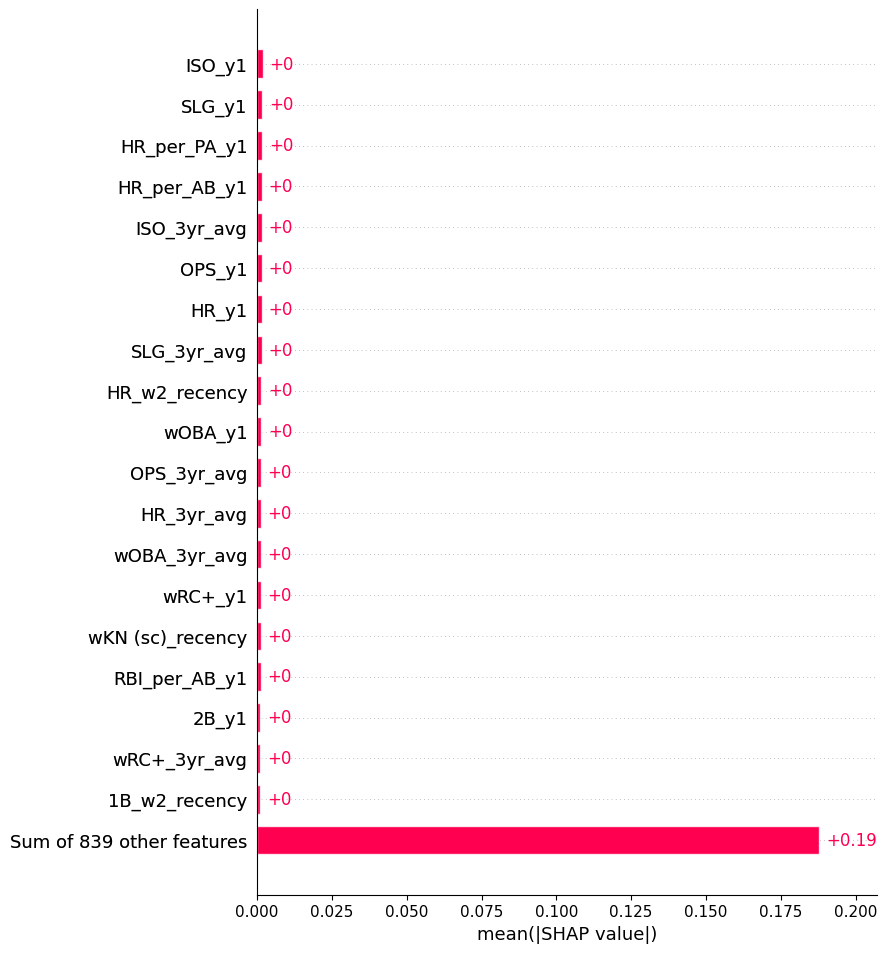

<Figure size 640x480 with 0 Axes>

In [20]:
# SHAP analysis for best model
best_model = top5[0][0]
X_test_np = X_test.detach().numpy()

explainer = shap.Explainer(
    lambda x: best_model(torch.tensor(x, dtype=torch.float32)).detach().numpy(),
    X_test_np,
    feature_names=features
)

shap_values = explainer(X_test_np, max_evals=2000)

# Don't pass ax, just call the function directly
shap.plots.bar(shap_values, max_display=20)
plt.tight_layout()
plt.show()

In [21]:
best_model.eval()

PlayerMLP(
  (model): Sequential(
    (0): ResidualBlock(
      (linear): Linear(in_features=858, out_features=512, bias=True)
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (activation): Sigmoid()
      (dropout): Dropout(p=0.4, inplace=False)
      (shortcut): Linear(in_features=858, out_features=512, bias=True)
    )
    (1): ResidualBlock(
      (linear): Linear(in_features=512, out_features=256, bias=True)
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (activation): Sigmoid()
      (dropout): Dropout(p=0.4, inplace=False)
      (shortcut): Linear(in_features=512, out_features=256, bias=True)
    )
    (2): ResidualBlock(
      (linear): Linear(in_features=256, out_features=128, bias=True)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (activation): Sigmoid()
      (dropout): Dropout(p=0.4, inplace=False)
      (shortcut): Linear(in_features=256, out_features=128, bias=True)
    )
    (3): ResidualBloc

Permutation explainer: 101it [01:40,  1.12s/it]                         


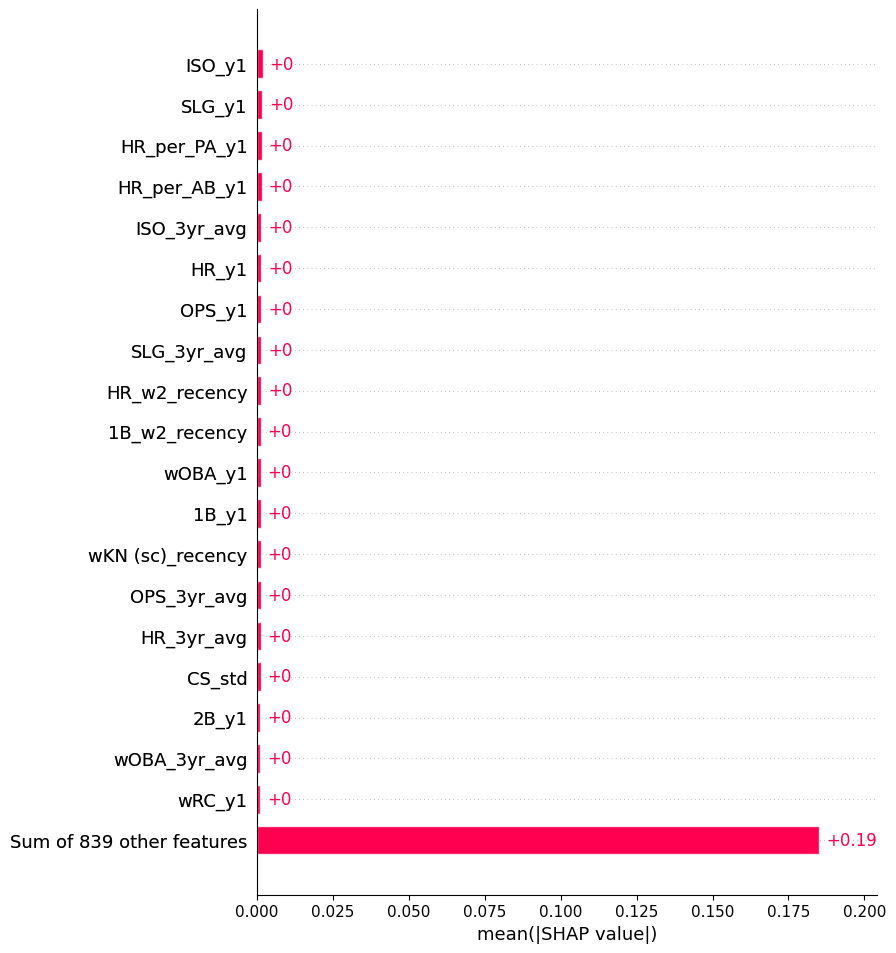

In [22]:
sample_size = min(100, X_test_np.shape[0])
sample_idx = np.random.choice(X_test_np.shape[0], size=sample_size, replace=False)

shap_values = explainer(X_test_np[sample_idx], max_evals=2 * X_test_np.shape[1] + 1)
shap.plots.bar(shap_values, max_display=20)


In [23]:
# SHAP analysis for best model
# Convert X_test to NumPy if it's a tensor
X_test_np = X_test.numpy()

# Create a wrapper function around your best_model to use with SHAP
def model_predict(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
    return best_model(x_tensor).detach().numpy()

# Create SHAP explainer
explainer = shap.Explainer(model_predict, X_test_np, feature_names=features)

# Compute SHAP values
shap_values = explainer(X_test_np, max_evals=2000)


Permutation explainer: 379it [06:15,  1.02s/it]                         


In [24]:
def get_top_shap_features(shap_values, feature_names, top_n=20):
    # Compute mean absolute SHAP value per feature
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    # Create a DataFrame of features ranked by importance
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'MeanAbsSHAP': mean_abs_shap
    }).sort_values(by='MeanAbsSHAP', ascending=False)

    top_features = shap_df['Feature'].head(top_n).tolist()
    return top_features, shap_df


In [81]:
top_features, shap_df = get_top_shap_features(shap_values, features, top_n=20)
shap_df.to_csv(f"../output/shap_summary_{TARGET_VAR}.csv", index=False)
print(f"Saved SHAP feature importance summary to ../output/shap_summary_{TARGET_VAR}.csv")


Saved SHAP feature importance summary to ../output/shap_summary_OPS.csv


### Ensemble Learning

Aggregate predictions from the top 5 MLP models (by RMSE) to compute an ensemble prediction for the final evaluation.


In [26]:
# Select top 5 models based on lowest RMSE
top5_results = sorted(top5, key=lambda x: x[1][2])[:5]
top5_models = [model for model, _ in top5_results]

# Get ensemble predictions by averaging outputs
with torch.no_grad():
    preds = np.stack([m(X_test).numpy().flatten() for m in top5_models], axis=1)
    ensemble_pred = preds.mean(axis=1)

# Compute final MAE and RMSE
y_true = y_test.numpy().flatten()
ensemble_mae = mean_absolute_error(y_true, ensemble_pred)
ensemble_rmse = mean_squared_error(y_true, ensemble_pred) ** 0.5

print(f"Ensemble (Top 5 Avg) → MAE: {ensemble_mae:.4f}, RMSE: {ensemble_rmse:.4f}")


Ensemble (Top 5 Avg) → MAE: 0.0566, RMSE: 0.0742


### Cross-Validation Utility (Standard MLP)

Evaluate the best hyperparameter configs using K-fold cross-validation.


In [27]:
from sklearn.model_selection import KFold

def cross_validate_mlp(X, y, config, n_splits=5):
    hidden_dims, lr, epochs, batch_size, dropout, _, activation, scheduler_type = config
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    maes = []
    rmses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{n_splits}")
        X_train_fold = torch.tensor(X[train_idx], dtype=torch.float32)
        y_train_fold = torch.tensor(y[train_idx], dtype=torch.float32).view(-1, 1)
        X_val_fold = torch.tensor(X[val_idx], dtype=torch.float32)
        y_val_fold = torch.tensor(y[val_idx], dtype=torch.float32).view(-1, 1)

        model = PlayerMLP(X.shape[1], hidden_dims, dropout, activation=activation).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
        if scheduler_type == 'cosine':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=2, eta_min=lr * 0.1
            )
        elif scheduler_type == 'plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=5, verbose=False
            )
        else:
            scheduler = None
        loss_fn = nn.MSELoss()

        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_train_fold, y_train_fold),
            batch_size=batch_size, shuffle=True
        )

        best_loss = float("inf")
        best_model_state = None

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                X_val_fold = X_val_fold.to(device)
                y_val_fold = y_val_fold.to(device)
                val_pred = model(X_val_fold)
                val_loss = loss_fn(val_pred, y_val_fold).item()
                if scheduler_type == 'plateau':
                    scheduler.step(val_loss)  # for ReduceLROnPlateau, pass val_loss
                elif scheduler_type == 'cosine':
                    scheduler.step(epoch)     # for CosineAnnealing, pass epoch

            if val_loss < best_loss:
                best_loss = val_loss
                best_model_state = model.state_dict()

        if best_model_state:
            model.load_state_dict(best_model_state)

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_fold.to(device)).cpu().numpy().flatten()
            y_true = y_val_fold.cpu().numpy().flatten()
            maes.append(mean_absolute_error(y_true, y_pred))
            rmses.append(mean_squared_error(y_true, y_pred) ** 0.5)

    print(f"\nCross-Validation Results (k={n_splits}):")
    print(f"MAE:  {np.mean(maes):.4f} ± {np.std(maes):.4f}")
    print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")


In [28]:
for i, (model, (cfg, mae, rmse)) in enumerate(top5):
    print(f"\n Cross-validating Top-{i+1} Config: {cfg}")
    cross_validate_mlp(X_scaled, y, cfg, n_splits=5)



 Cross-validating Top-1 Config: ([512, 256, 128, 64], 0.005, 150, 128, 0.4, 0.1, 'sigmoid', 'plateau')
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0613 ± 0.0025
RMSE: 0.0782 ± 0.0030

 Cross-validating Top-2 Config: ([64, 32, 16, 8, 4], 0.001, 150, 64, 0.5, 0.1, 'swish', 'cosine')
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0637 ± 0.0018
RMSE: 0.0809 ± 0.0022

 Cross-validating Top-3 Config: ([128, 64, 32, 16, 8], 0.001, 50, 64, 0.4, 0.2, 'sigmoid', 'cosine')
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0621 ± 0.0043
RMSE: 0.0795 ± 0.0039

 Cross-validating Top-4 Config: ([128, 64, 32], 0.01, 150, 128, 0.2, 0.2, 'relu', 'plateau')
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0617 ± 0.0023
RMSE: 0.0786 ± 0.0023

 Cross-validating Top-5 Config: ([64, 32, 16, 8], 0.01, 50, 64, 0.4, 0.1, 'leaky_relu', 'plateau')
Fold 1/5
Fold

In [29]:
top_features, shap_df = get_top_shap_features(shap_values, features, top_n=20)
print("\nTop 20 SHAP Features:")
for feature in top_features:
    print(feature)


Top 20 SHAP Features:
ISO_y1
SLG_y1
HR_per_PA_y1
HR_per_AB_y1
ISO_3yr_avg
OPS_y1
HR_y1
SLG_3yr_avg
HR_w2_recency
wOBA_y1
OPS_3yr_avg
HR_3yr_avg
wOBA_3yr_avg
wRC+_y1
wKN (sc)_recency
RBI_per_AB_y1
2B_y1
wRC+_3yr_avg
1B_w2_recency
RBI_per_PA_y1


In [30]:
# Get indices of top SHAP-ranked features
top_feature_indices = [features.index(f) for f in top_features]

# Convert tensors to NumPy arrays
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()

# Subset to top features
X_train_reduced = X_train_np[:, top_feature_indices]
X_test_reduced = X_test_np[:, top_feature_indices]

# Optionally: rescale reduced data
scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

cross_validate_mlp(X_train_reduced_scaled, y, top5[0][1][0], n_splits=5)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0836 ± 0.0028
RMSE: 0.1064 ± 0.0043


In [31]:
ensemble_preds = []
top5_models = []

for i, (model, (cfg, mae, rmse)) in enumerate(top5):
    print(f"\n Training Top-{i+1} Config: {cfg}")
    hidden_dims, lr, epochs, batch_size, dropout, val_split, activation, scheduler_type = cfg

    # Split again using new features
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Convert to torch
    X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_split, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_split, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_split, dtype=torch.float32).view(-1, 1)

    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)


    model = PlayerMLP(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=activation,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    if scheduler_type == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=lr * 0.1
        )
    elif scheduler_type == 'plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=False
        )
    else:
        scheduler = None
    loss_fn = nn.MSELoss()

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size,
        shuffle=True
    )

    best_loss = float("inf")
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_test_tensor)
            val_loss = loss_fn(val_pred, y_test_tensor).item()
            if scheduler_type == 'plateau':
                scheduler.step(val_loss)  # for ReduceLROnPlateau, pass val_loss
            elif scheduler_type == 'cosine':
                scheduler.step(epoch)     # for CosineAnnealing, pass epoch

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()

    if best_model_state:
        model.load_state_dict(best_model_state)

    # Save model + predictions
    top5_models.append(model)
    with torch.no_grad():
        preds = model(X_test_tensor).cpu().numpy().flatten()
        ensemble_preds.append(preds)

# Average predictions
ensemble_preds_avg = np.mean(ensemble_preds, axis=0)
ensemble_mae = mean_absolute_error(y_test_tensor.cpu().numpy().flatten(), ensemble_preds_avg)
ensemble_rmse = mean_squared_error(y_test_tensor.cpu().numpy().flatten(), ensemble_preds_avg) ** 0.5

print(f"\n Ensemble on Engineered Features → MAE: {ensemble_mae:.4f}, RMSE: {ensemble_rmse:.4f}")



 Training Top-1 Config: ([512, 256, 128, 64], 0.005, 150, 128, 0.4, 0.1, 'sigmoid', 'plateau')

 Training Top-2 Config: ([64, 32, 16, 8, 4], 0.001, 150, 64, 0.5, 0.1, 'swish', 'cosine')

 Training Top-3 Config: ([128, 64, 32, 16, 8], 0.001, 50, 64, 0.4, 0.2, 'sigmoid', 'cosine')

 Training Top-4 Config: ([128, 64, 32], 0.01, 150, 128, 0.2, 0.2, 'relu', 'plateau')

 Training Top-5 Config: ([64, 32, 16, 8], 0.01, 50, 64, 0.4, 0.1, 'leaky_relu', 'plateau')

 Ensemble on Engineered Features → MAE: 0.0606, RMSE: 0.0783


### Save Models and Metadata

Store trained models, scalers, and features on disk under `ensemble_engineered/` for reuse and prediction.


In [35]:
import joblib
import os
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Save Ensemble Models and Assets ===
os.makedirs("ensemble_engineered", exist_ok=True)

# Save each model
for i, model in enumerate(top5_models):
    torch.save(model.state_dict(), f"ensemble_engineered/mlp_model_{i}_{TARGET_VAR}.pt")

# Save scaler and feature names
joblib.dump(scaler, f"ensemble_engineered/scaler_{TARGET_VAR}.joblib")
joblib.dump(features, f"ensemble_engineered/features_{TARGET_VAR}.joblib")

# Also save the X_test and y_test used at ensemble training time
np.save(f"ensemble_engineered/X_test_split_{TARGET_VAR}.npy", X_test_split)
np.save(f"ensemble_engineered/y_test_split_{TARGET_VAR}.npy", y_test_split)

print("Saved ensemble models, scaler, features, and test split.")

def load_ensemble_and_predict(X_input_np):
    # Do NOT re-load and re-apply scaler — input is already scaled
    X_tensor = torch.tensor(X_input_np, dtype=torch.float32).to(device)

    # Predict with ensemble
    ensemble_preds = []
    for i in range(5):
        config = top5[i][1][0]
        hidden_dims, lr, epochs, batch_size, dropout, val_split, activation, scheduler_type = config

        model = PlayerMLP(
            input_dim=X_tensor.shape[1],
            hidden_dims=hidden_dims,
            dropout=dropout,
            activation=activation
        ).to(device)
        model.load_state_dict(torch.load(f"ensemble_engineered/mlp_model_{i}_{TARGET_VAR}.pt"))
        model.eval()
        with torch.no_grad():
            preds = model(X_tensor).cpu().numpy().flatten()
            ensemble_preds.append(preds)

    return np.mean(ensemble_preds, axis=0)

X_test_loaded = np.load(f"ensemble_engineered/X_test_split_{TARGET_VAR}.npy")
y_test_loaded = np.load(f"ensemble_engineered/y_test_split_{TARGET_VAR}.npy")

y_pred_saved = load_ensemble_and_predict(X_test_loaded)

mae_saved = mean_absolute_error(y_test_loaded, y_pred_saved)
rmse_saved = mean_squared_error(y_test_loaded, y_pred_saved) ** 0.5

print(f"Final Ensemble Check → MAE: {mae_saved:.4f}, RMSE: {rmse_saved:.4f}")



Saved ensemble models, scaler, features, and test split.
Final Ensemble Check → MAE: 0.0606, RMSE: 0.0783


In [36]:
print("X_train shape:", X_train_split.shape)
print("y_train shape:", y_train_split.shape)
assert not np.isnan(X_train_split).any()
assert not np.isinf(X_train_split).any()

X_train shape: (1511, 858)
y_train shape: (1511,)


### Train Tree-Based Models

Train and compare XGBoost and CatBoost regressors on the same train/test split used by the MLP models.


In [37]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
import time

# Store results
tree_results = []

# === XGBoost ===
print("Fitting XGBoost...")
start_time = time.time()
xgb_model = XGBRegressor(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=1,          # Limit threads
    verbosity=2        # More verbose logging
)
xgb_model.fit(X_train_split, y_train_split)
y_pred_xgb = xgb_model.predict(X_test_split)
tree_results.append(("XGBoost", mean_absolute_error(y_test_split, y_pred_xgb), mean_squared_error(y_test_split, y_pred_xgb) ** 0.5))
print(f"XGBoost Training Time: {time.time() - start_time:.2f} seconds")


Fitting XGBoost...
[16:08:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:08:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:08:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:08:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:08:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pru

In [38]:
# === CatBoost ===
print("Fitting CatBoost...")
start_time = time.time()
cat_model = CatBoostRegressor(iterations=50, learning_rate=0.05, depth=6, random_state=42, verbose=10, task_type="CPU")
cat_model.fit(X_train_split, y_train_split)
y_pred_cat = cat_model.predict(X_test_split)
tree_results.append(("CatBoost", mean_absolute_error(y_test_split, y_pred_cat), mean_squared_error(y_test_split, y_pred_cat) ** 0.5))
print(f"CatBoost Training Time: {time.time() - start_time:.2f} seconds")

Fitting CatBoost...
0:	learn: 0.1037817	total: 75.2ms	remaining: 3.69s
10:	learn: 0.0896714	total: 212ms	remaining: 752ms
20:	learn: 0.0818704	total: 339ms	remaining: 468ms
30:	learn: 0.0771373	total: 468ms	remaining: 287ms
40:	learn: 0.0741858	total: 603ms	remaining: 132ms
49:	learn: 0.0721440	total: 724ms	remaining: 0us
CatBoost Training Time: 1.07 seconds


In [39]:
# === Print Results ===
print("\nTree-Based Model Comparison:")
for name, mae, rmse in tree_results:
    print(f"{name:<10} → MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Tree-Based Model Comparison:
XGBoost    → MAE: 0.0644, RMSE: 0.0840
CatBoost   → MAE: 0.0616, RMSE: 0.0808


# hyperparameter tuning for tree-based models

In [57]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import time

# Reuse these train/test splits from earlier
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === XGBoost Grid ===
xgb_params = {
    "n_estimators": [100, 300, 500, 1000],
    "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
    "max_depth": [None, 1, 2, 4, 6, 8, 10, 12]
}

xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42, verbosity=0),
    xgb_params,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

print("Tuning XGBoost...")
start = time.time()
xgb_grid.fit(X_train_split, y_train_split)
print(f"XGBoost Best Params: {xgb_grid.best_params_}")
print(f"XGBoost Tuning Time: {time.time() - start:.2f}s")


Tuning XGBoost...


XGBoost Best Params: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 300}
XGBoost Tuning Time: 1329.69s


In [61]:
# === CatBoost Grid ===
cat_params = {
    "iterations": [100, 300, 500, 1000],
    "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
    "depth": [2, 4, 6, 8, 10, 12]
}

cat_grid = GridSearchCV(
    CatBoostRegressor(random_state=42, verbose=0, task_type="CPU"),
    cat_params,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

print("\nTuning CatBoost...")
start = time.time()
cat_grid.fit(X_train_split, y_train_split)
print(f"CatBoost Best Params: {cat_grid.best_params_}")
print(f"CatBoost Tuning Time: {time.time() - start:.2f}s")



Tuning CatBoost...
CatBoost Best Params: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.01}
CatBoost Tuning Time: 20835.50s


In [62]:
# === Random Forest Grid ===
rf_params = {
    "n_estimators": [100, 300, 500, 1000],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

print("\nTuning Random Forest...")
start = time.time()
rf_grid.fit(X_train_split, y_train_split)
print(f"Random Forest Best Params: {rf_grid.best_params_}")
print(f"RF Tuning Time: {time.time() - start:.2f}s")


Tuning Random Forest...
Random Forest Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 1000}
RF Tuning Time: 1375.18s


In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

for name, model in [("XGBoost", xgb_grid.best_estimator_), ("CatBoost", cat_grid.best_estimator_), ("Random Forest", rf_grid.best_estimator_)]:
    y_pred = model.predict(X_test_split)
    mae = mean_absolute_error(y_test_split, y_pred)
    rmse = mean_squared_error(y_test_split, y_pred) ** 0.5
    print(f"{name:<15} → MAE: {mae:.4f}, RMSE: {rmse:.4f}")


XGBoost         → MAE: 0.0605, RMSE: 0.0784
CatBoost        → MAE: 0.0601, RMSE: 0.0782
Random Forest   → MAE: 0.0599, RMSE: 0.0777


In [64]:
import joblib

# Save tuned models
joblib.dump(xgb_grid.best_estimator_, f'ensemble_engineered/xgb_best_{TARGET_VAR}.joblib')
joblib.dump(cat_grid.best_estimator_, f'ensemble_engineered/cat_best_{TARGET_VAR}.joblib')
joblib.dump(rf_grid.best_estimator_, f'ensemble_engineered/rf_best_{TARGET_VAR}.joblib')

print("Saved tuned tree-based models.")


Saved tuned tree-based models.


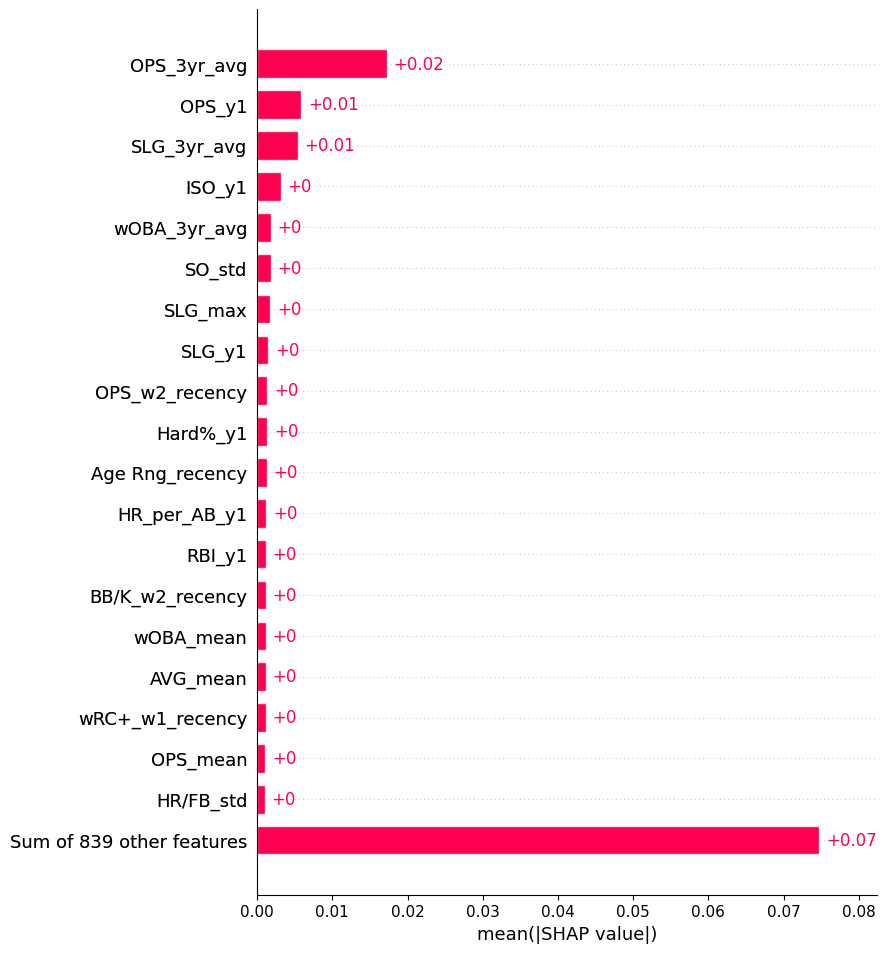

In [65]:
X_train_df = pd.DataFrame(X_train_split, columns=features)
X_test_df = pd.DataFrame(X_test_split, columns=features)

explainer = shap.Explainer(xgb_model, X_train_df)
shap_values = explainer(X_test_df)
shap.plots.bar(shap_values, max_display=20)

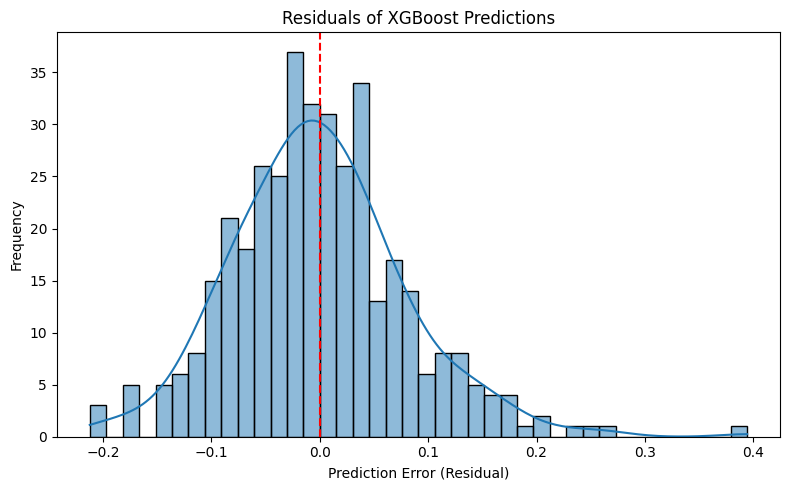

In [66]:
import seaborn as sns

residuals = y_test_split - y_pred_cat

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residuals of XGBoost Predictions")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


### SHAP Feature Importance for CatBoost

Use SHAP values to inspect the top features driving predictions in the CatBoost model.


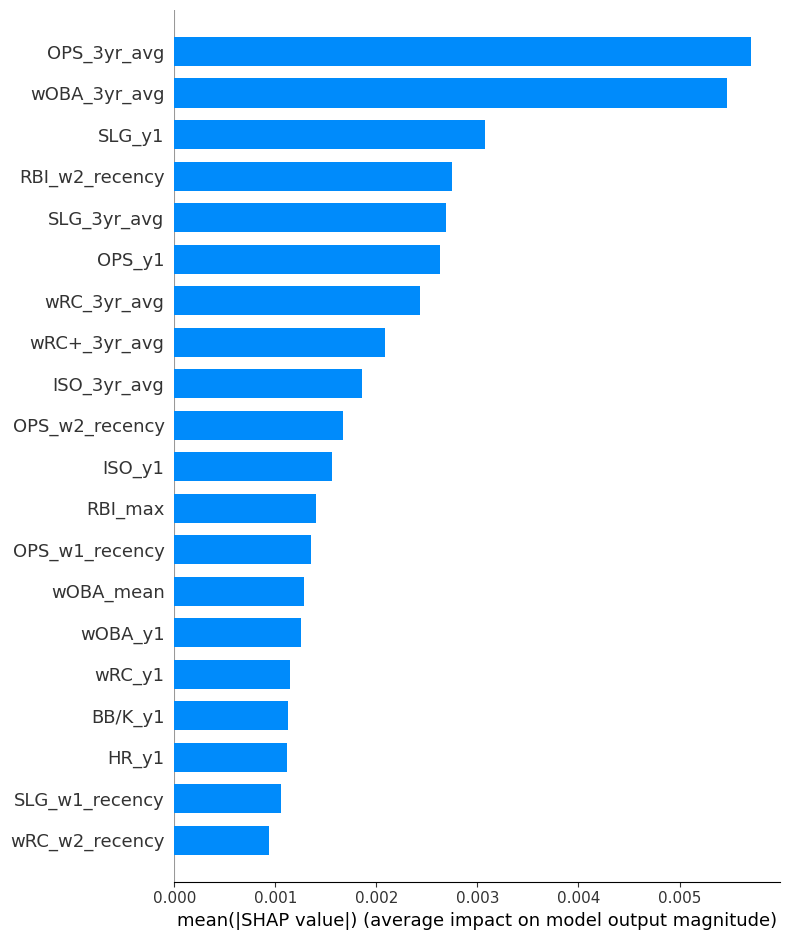

In [67]:

# CatBoost SHAP values (last column is base value)
cat_pool = Pool(X_test_split, label=y_test_split, feature_names=features)
raw_shap_values = cat_model.get_feature_importance(type='ShapValues', data=cat_pool)
shap_values = raw_shap_values[:, :-1]  # remove base value column

# Safe and clean SHAP summary bar plot
shap.summary_plot(
    shap_values,
    X_test_split,
    feature_names=features,
    plot_type="bar"
)


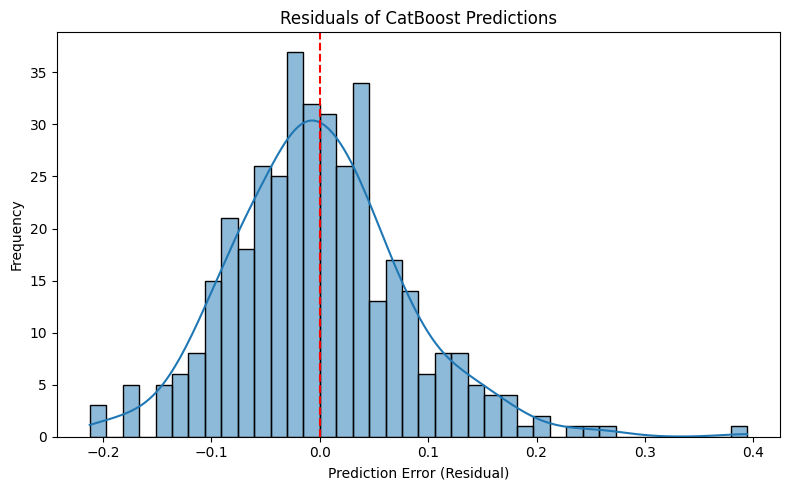

In [68]:
import seaborn as sns

residuals = y_test_split - y_pred_cat

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residuals of CatBoost Predictions")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


In [ ]:
xgb_model = joblib.load(f'ensemble_engineered/xgb_best_{TARGET_VAR}.joblib')
cat_model = joblib.load(f'ensemble_engineered/cat_best_{TARGET_VAR}.joblib')
rf_model = joblib.load(f'ensemble_engineered/rf_best_{TARGET_VAR}.joblib')

 99%|===================| 375/378 [02:18<00:01]        

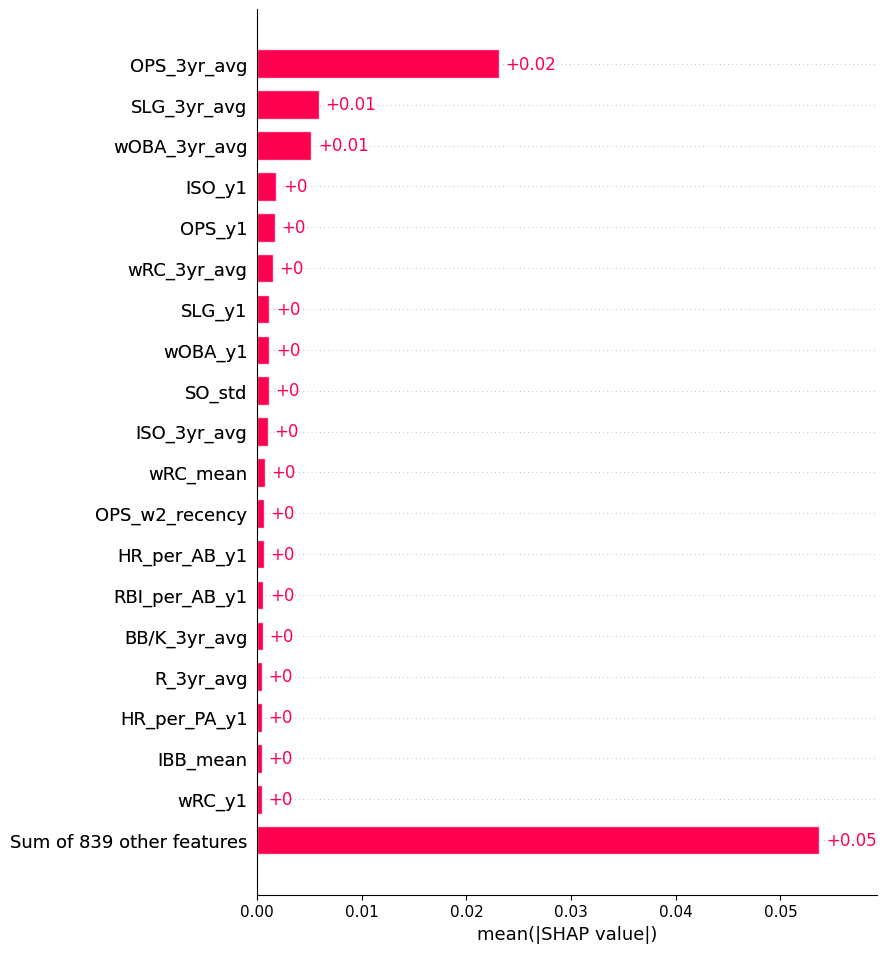

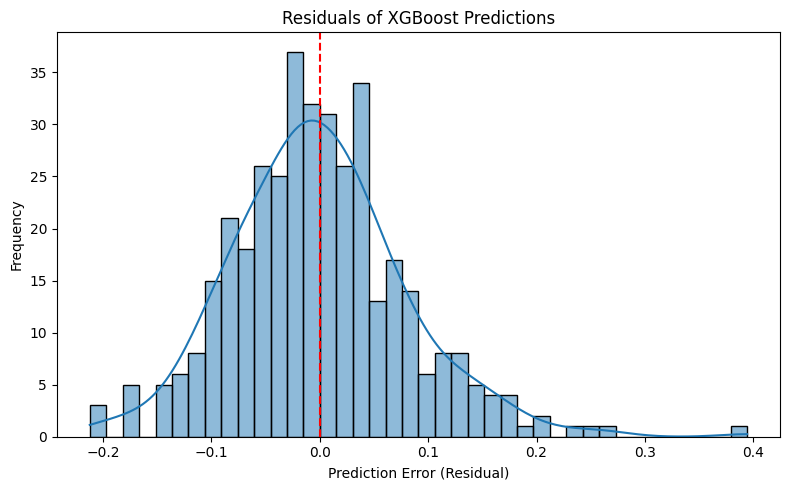

In [80]:
# for random forest
X_train_df = pd.DataFrame(X_train_split, columns=features)
X_test_df = pd.DataFrame(X_test_split, columns=features)

explainer = shap.Explainer(rf_model, X_train_df)
shap_values = explainer(X_test_df)
shap.plots.bar(shap_values, max_display=20)
import seaborn as sns

residuals = y_test_split - y_pred_cat

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residuals of XGBoost Predictions")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


# Stacked Model

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

# === STACKING ===
print("\nTraining Stacked Model...")

# Create stack inputs
stack_features = []

# 1. Predictions from top 5 MLPs
with torch.no_grad():
    for model in top5_models:
        preds = model(X_test_tensor).cpu().numpy().flatten()
        stack_features.append(preds)

# 2. Predictions from XGBoost
xgb_preds = xgb_model.predict(X_test_split)
stack_features.append(xgb_preds)

# 3. Predictions from CatBoost
cat_preds = cat_model.predict(X_test_split)
stack_features.append(cat_preds)

# 4. Predictions from tuned Random Forest
rf_preds = rf_model.predict(X_test_split)
stack_features.append(rf_preds)

# Stack into a (num_samples, 7) array
X_stack = np.vstack(stack_features).T  # shape = (N, 7)

# Meta-learner training
meta_model = Ridge(alpha=1.0)  # Or you could try GradientBoostingRegressor
meta_model.fit(X_stack, y_test_split)

# Predictions from meta-model
meta_preds = meta_model.predict(X_stack)

# Evaluate
meta_mae = mean_absolute_error(y_test_split, meta_preds)
meta_rmse = mean_squared_error(y_test_split, meta_preds) ** 0.5

print(f"Stacked Model → MAE: {meta_mae:.4f}, RMSE: {meta_rmse:.4f}")



Training Stacked Model...
Stacked Model → MAE: 0.0592, RMSE: 0.0771


### Predicting 2025 Performance

Use the trained ensemble, XGBoost, and CatBoost models to make predictions for the 2025 season based on 2024 player stats.


In [70]:
from pybaseball import batting_stats
import pandas as pd

# Pull latest data
df_2024 = batting_stats(2024)
df_2024['Season'] = 2024

years[2024] = df_2024


# All history up to 2023
history_years = [years[y] for y in range(1900, 2024) if y in years]
df_history = pd.concat(history_years)
valid_cols = [col for col in feature_cols if col in df_history.columns]

# Rolling aggregates from 1900–2023
agg = (
    df_history
    .groupby("Name")[valid_cols]
    .agg(['mean', 'std', 'max', 'sum'])
)
agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
agg = agg.reset_index()

# Build *_y1 features
df_y1 = df_2024.copy()
y1_features = df_y1[['Name'] + [col for col in feature_cols if col in df_y1.columns]].copy()
y1_features.columns = [f"{col}_y1" if col != "Name" else "Name" for col in y1_features.columns]

# Merge historical aggregates with 2024
df_future = pd.merge(y1_features, agg, on="Name", how="inner")
# === TEAM Target Encoding (2025) ===
if 'Team' in df_2024.columns:
    team_means = (
        df_history.groupby('Team')[TARGET_VAR]
        .mean()
        .to_dict()
    )
    df_future['Team_encoded'] = df_2024['Team'].map(team_means).fillna(df_history[TARGET_VAR].mean())

# === POSITION Target Encoding (2025) ===
if 'Pos' in df_2024.columns:
    pos_means = (
        df_history.groupby('Pos')[TARGET_VAR]
        .mean()
        .to_dict()
    )
    df_future['Pos_encoded'] = df_2024['Pos'].map(pos_means).fillna(df_history[TARGET_VAR].mean())

if 'Team' in df_2024.columns:
    df_future['Team_recency'] = df_2024['Team']
    team_dummies = pd.get_dummies(df_future['Team_recency'], prefix='Team')
    df_future = pd.concat([df_future.drop(columns='Team_recency'), team_dummies], axis=1)


for base in ['HR', 'WAR', 'BB', 'SO', 'SB', 'CS', 'RBI', 'H']:
    if f"{base}_y1" in df_future.columns and "PA_y1" in df_future.columns:
        df_future[f"{base}_per_PA_y1"] = df_future[f"{base}_y1"] / (df_future["PA_y1"] + 1e-5)
    if f"{base}_y1" in df_future.columns and "AB_y1" in df_future.columns:
        df_future[f"{base}_per_AB_y1"] = df_future[f"{base}_y1"] / (df_future["AB_y1"] + 1e-5)


# Position encoding
if 'Pos' in df_2024.columns:
    pos_df = df_2024[['Name', 'Pos']].copy()
    pos_df['Pos'] = pos_df['Pos'].astype(str).fillna('UNK').str.split('-').str[0]
    pos_dummies = pd.get_dummies(pos_df['Pos'], prefix='Pos')
    pos_encoded = pd.concat([pos_df[['Name']], pos_dummies], axis=1)
    df_future = pd.merge(df_future, pos_encoded, on='Name', how='left')

# Add 2022, 2023, and 2024 for rolling averages
rolling_years = [years[y] for y in range(2022, 2025) if y in years]
if len(rolling_years) == 3:
    df_rolling = pd.concat(rolling_years)
    df_rolling_avg = (
        df_rolling.groupby("Name")[feature_cols]
        .mean()
        .reset_index()
    )
    df_rolling_avg.columns = ['Name'] + [f"{col}_3yr_avg" for col in df_rolling_avg.columns[1:]]
    df_future = pd.merge(df_future, df_rolling_avg, on="Name", how="left")

# Add recency-weighted features
weights = [0.6, 0.3, 0.1]
recency_years = [years.get(y) for y in range(2022, 2025) if years.get(y) is not None]
if len(recency_years) == 3:
    df_weighted = recency_years[0].copy()
    for col in feature_cols:
        if col in df_weighted.columns:
            df_weighted[col] = weights[0] * df_weighted[col]
    for i in range(1, 3):
        df_temp = recency_years[i][['Name'] + [col for col in feature_cols if col in recency_years[i].columns]].copy()
        for col in feature_cols:
            if col in df_temp.columns:
                df_temp[col] = weights[i] * df_temp[col]
        df_weighted = pd.merge(df_weighted, df_temp, on="Name", how="outer", suffixes=('', f'_w{i}'))

    df_weighted = df_weighted.fillna(0)
    weighted_sums = df_weighted.groupby("Name").sum().reset_index()
    weighted_sums.columns = ['Name'] + [f"{col}_recency" for col in weighted_sums.columns[1:]]
    df_future = pd.merge(df_future, weighted_sums, on="Name", how="left")

# Check missing columns
expected_features = joblib.load(f"ensemble_engineered/features_{TARGET_VAR}.joblib")
df_future_columns = set(df_future.columns)

missing_in_future = [col for col in expected_features if col not in df_future_columns]

# Fill missing expected columns with 0
for col in expected_features:
    if col not in df_future.columns:
        df_future[col] = 0

# Reorder columns to match exactly
df_future = df_future[expected_features]

# Check missing columns
expected_features = joblib.load(f"ensemble_engineered/features_{TARGET_VAR}.joblib")
df_future_columns = set(df_future.columns)

missing_in_future = [col for col in expected_features if col not in df_future_columns]
print(f"Missing features in 2024: {missing_in_future}")
print(" Built 2025 prediction input set:", df_future.shape)


Missing features in 2024: []
 Built 2025 prediction input set: (94, 858)


In [71]:
features = joblib.load(f"ensemble_engineered/features_{TARGET_VAR}.joblib")
print("Expected input feature count:", len(features))

Expected input feature count: 858


In [72]:
# === Clean non-numeric feature columns for df_future ===

# 1. Clean Age Rng_recency
if 'Age Rng_recency' in df_future.columns:
    df_future['Age Rng_recency'] = (
        df_future['Age Rng_recency']
        .astype(str)
        .str.extract(r'(\d+)')
        .astype(float)
    )

# 2. Clean Dol_recency
if 'Dol_recency' in df_future.columns:
    df_future['Dol_recency'] = (
        df_future['Dol_recency']
        .astype(str)
        .str.replace(r'[^\d.\-]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

# 3. One-hot encode 'Team_recency' again if necessary
if 'Team_recency' in df_future.columns:
    team_dummies = pd.get_dummies(df_future['Team_recency'], prefix='Team')
    df_future = pd.concat([df_future.drop(columns='Team_recency'), team_dummies], axis=1)

# 4. Safety check: confirm all features are numeric
non_numeric = df_future.select_dtypes(include=['object']).columns.tolist()
if non_numeric:
    print("Still contains non-numeric features:", non_numeric)
    raise ValueError("Fix non-numeric columns before scaling.")


In [73]:
# Load model assets
scaler = joblib.load(f"ensemble_engineered/scaler_{TARGET_VAR}.joblib")
features = joblib.load(f"ensemble_engineered/features_{TARGET_VAR}.joblib")

# Prepare input
df_pred = df_future.copy()
X_pred = df_pred[features].fillna(0).values
X_pred_scaled = scaler.transform(X_pred)
X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32)

# Predict
ensemble_preds = []
for i, (model, (cfg, mae, rmse)) in enumerate(top5):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        preds = model(X_pred_tensor.to(device)).cpu().numpy().flatten()
        ensemble_preds.append(preds)

df_pred[f"{TARGET_VAR}_2025_pred_MLP"] = np.mean(ensemble_preds, axis=0)
print("MLP Ensemble 2025 predictions complete")


MLP Ensemble 2025 predictions complete


In [74]:
# Load best tuned models from disk
xgb_model = joblib.load(f'ensemble_engineered/xgb_best_{TARGET_VAR}.joblib')
cat_model = joblib.load(f'ensemble_engineered/cat_best_{TARGET_VAR}.joblib')
rf_model = joblib.load(f'ensemble_engineered/rf_best_{TARGET_VAR}.joblib')

# Predict using tuned models
df_pred[f"{TARGET_VAR}_2025_pred_XGBoost"] = xgb_model.predict(X_pred_scaled)
df_pred[f"{TARGET_VAR}_2025_pred_CatBoost"] = cat_model.predict(X_pred_scaled)
df_pred[f"{TARGET_VAR}_2025_pred_RandomForest"] = rf_model.predict(X_pred_scaled)

print("XGBoost, CatBoost, and Random Forest 2025 predictions complete")

XGBoost, CatBoost, and Random Forest 2025 predictions complete


In [76]:
# === Rebuild full 2025 stack input with 8 features ===
stack_features_2025 = []

# 1–5. Individual MLP model predictions
with torch.no_grad():
    for model in top5_models:
        model.eval()
        preds = model(X_pred_tensor.to(device)).cpu().numpy().flatten()
        stack_features_2025.append(preds)

# 6. XGBoost
stack_features_2025.append(df_pred[f"{TARGET_VAR}_2025_pred_XGBoost"].values)

# 7. CatBoost
stack_features_2025.append(df_pred[f"{TARGET_VAR}_2025_pred_CatBoost"].values)

# 8. Random Forest
stack_features_2025.append(df_pred[f"{TARGET_VAR}_2025_pred_RandomForest"].values)

# Final stack input (shape = N x 8)
X_stack_2025 = np.vstack(stack_features_2025).T

# Predict with trained meta model
df_pred[f"{TARGET_VAR}_2025_pred_Stacked"] = meta_model.predict(X_stack_2025)
print("Stacked model 2025 predictions complete.")

# Save the updated meta model (optional if not done already)
joblib.dump(meta_model, f'ensemble_engineered/meta_model_stacked_{TARGET_VAR}.joblib')


Stacked model 2025 predictions complete.


['ensemble_engineered/meta_model_stacked_OPS.joblib']

In [77]:
# Use the best RMSE values computed during test-time evaluation
# Suppose you have a dictionary of RMSEs from previous evaluations:
rmse_scores = {
    'MLP': ensemble_rmse,
    'XGBoost': mean_squared_error(y_test_split, xgb_model.predict(X_test_split)) ** 0.5,
    'CatBoost': mean_squared_error(y_test_split, cat_model.predict(X_test_split)) ** 0.5,
    'RandomForest': mean_squared_error(y_test_split, rf_model.predict(X_test_split)) ** 0.5,
    'Stacked': meta_rmse,
}

# Choose the best model name
best_model_name = min(rmse_scores, key=rmse_scores.get)
best_model_col = f"{TARGET_VAR}_2025_pred_{best_model_name}"

print(f"\n Best model based on test RMSE: {best_model_name} ({rmse_scores[best_model_name]:.4f})")



 Best model based on test RMSE: Stacked (0.0771)


In [78]:
output_cols = [
    'Name',
    f"{TARGET_VAR}_2025_pred_MLP",
    f"{TARGET_VAR}_2025_pred_XGBoost",
    f"{TARGET_VAR}_2025_pred_CatBoost",
    f"{TARGET_VAR}_2025_pred_RandomForest",
    f"{TARGET_VAR}_2025_pred_Stacked"
]

df_pred = pd.concat([df_y1[['Name']], df_pred], axis=1)

df_pred_filtered = df_pred.dropna(subset=[
    f"{TARGET_VAR}_2025_pred_MLP",
    f"{TARGET_VAR}_2025_pred_XGBoost",
    f"{TARGET_VAR}_2025_pred_CatBoost",
    f"{TARGET_VAR}_2025_pred_RandomForest"
])

# Choose best model output (e.g., from evaluation)
df_pred[f"{TARGET_VAR}_2025_pred_Final"] = df_pred[best_model_col]
if f"{TARGET_VAR}_2025_pred_Final" not in output_cols:
    output_cols.append(f"{TARGET_VAR}_2025_pred_Final")

df_pred_filtered = df_pred.dropna(subset=output_cols)


df_pred_filtered[output_cols].to_csv(f"../output/2025_{TARGET_VAR}_predictions.csv", index=False)
print(f"Saved 2025 predictions to output/2025_{TARGET_VAR}_predictions.csv")


Saved 2025 predictions to output/2025_OPS_predictions.csv


In [79]:
rmse_df = pd.DataFrame(rmse_scores, index=["RMSE"]).T.sort_values(by="RMSE")
rmse_df.to_csv(f"../output/2025_{TARGET_VAR}_rmse_summary.csv")
print("Saved RMSE summary to CSV.")


Saved RMSE summary to CSV.
